# Market Basket Analysis with RFM analysis

< Context about project >

Importing the Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans #For customer segmentation
from sklearn.preprocessing import StandardScaler

In [2]:
#Proprocessing the dataset
sheet1 = pd.read_excel("online_retail_II.xlsx",sheet_name = "Year 2009-2010")
sheet2 = pd.read_excel("online_retail_II.xlsx",sheet_name = "Year 2010-2011")
print(sheet1.head(5))
print(sheet2.head(5))

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365

##### Understanding the dataset

In this dataset we have the rows "Invoice", "StockCode", "Description", "Quanitity", "InvoiceDate" ,"Price", "Customer ID", "Country". 
<< Explain about each row >>
We need to understand about the datatype of each row

In [3]:
dataframe = pd.concat([sheet1,sheet2],ignore_index = True)
dataframe.shape

(1067371, 8)

In [4]:
dataframe.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In the dataset we are combining two different years together, there might be some duplicate transactions in the list. We will be removing them

In [5]:
duplicate_rows = dataframe[dataframe.duplicated()]
print("The duplicate entries are:"+"\n",duplicate_rows)

The duplicate entries are:
         Invoice StockCode                        Description  Quantity  \
371      489517     21912           VINTAGE SNAKES & LADDERS         1   
383      489517     22130   PARTY CONE CHRISTMAS DECORATION          6   
384      489517     22319  HAIRCLIPS FORTIES FABRIC ASSORTED        12   
385      489517     21913     VINTAGE SEASIDE JIGSAW PUZZLES         1   
386      489517     21821   GLITTER STAR GARLAND WITH BELLS          1   
...         ...       ...                                ...       ...   
1067136  581538     22068        BLACK PIRATE TREASURE CHEST         1   
1067150  581538     23318     BOX OF 6 MINI VINTAGE CRACKERS         1   
1067153  581538     22992             REVOLVER WOODEN RULER          1   
1067160  581538     22694                       WICKER STAR          1   
1067162  581538     23343       JUMBO BAG VINTAGE CHRISTMAS          1   

                InvoiceDate  Price  Customer ID         Country  
371     2009-12-0

In [6]:
unique_df = dataframe.drop_duplicates()
print(unique_df)

        Invoice StockCode                          Description  Quantity  \
0        489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1        489434    79323P                   PINK CHERRY LIGHTS        12   
2        489434    79323W                  WHITE CHERRY LIGHTS        12   
3        489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4        489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...         ...       ...                                  ...       ...   
1067366  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                              POSTAGE         1   

                InvoiceDate  Price  Customer ID         Country  
0       2009-12-01 07

Now that the duplicates are removed, we can use this for performing market basket analysis

In [7]:
print(unique_df.isnull().sum())

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235151
Country             0
dtype: int64


As we are going to perform RBF analysis along with Market Basket Analysis we can remove all the rows that dont have a customerID with them.

In [8]:
mba_rbf_df = unique_df.dropna(subset = ['Customer ID'])

We are going to use the above dataset to perform both Market Basket and RBF Analysis

## Market Basket Analysis

In [9]:
basket = (mba_rbf_df.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))
print(basket)

Description    DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                       
489434                                       0.0                        0.0   
489435                                       0.0                        0.0   
489436                                       0.0                        0.0   
489437                                       0.0                        0.0   
489438                                       0.0                        0.0   
...                                          ...                        ...   
C581484                                      0.0                        0.0   
C581490                                      0.0                        0.0   
C581499                                      0.0                        0.0   
C581568                                      0.0                        0.0   
C581569                                      0.0    

In [10]:
basket.describe()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
count,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,...,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000
mean,0.003721,0.014707,0.007220,0.041960,0.008579,0.001003,0.000802,0.000022,0.000958,0.006797,...,0.000178,0.001315,0.005437,0.044991,0.000535,0.108076,0.005148,0.137133,0.000557,0.001783
std,0.148709,0.532243,0.382097,2.038941,0.555944,0.072050,0.077850,0.008176,0.089188,0.974058,...,0.037764,0.084302,0.178678,1.058302,0.080110,2.674138,0.222611,2.106766,0.039773,0.136315
min,0.000000,-2.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-2.000000,...,0.000000,0.000000,-4.000000,-10.000000,0.000000,-24.000000,-4.000000,-12.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,80.000000,36.000000,400.000000,48.000000,10.000000,12.000000,1.000000,12.000000,204.000000,...,8.000000,12.000000,24.000000,96.000000,12.000000,216.000000,16.000000,192.000000,4.000000,24.000000


In [11]:
basket_sets = basket.apply(lambda x: x.map(lambda y: 1 if y > 0 else 0))

In [12]:
freq_items = fpgrowth(basket_sets,min_support = 0.01,use_colnames = True)
freq_items

C:\Users\prith\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.040512,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.013370,(SAVE THE PLANET MUG)
2,0.010674,(PINK DOUGHNUT TRINKET POT )
3,0.059096,(ASSORTED COLOUR BIRD ORNAMENT)
4,0.040801,(HOME BUILDING BLOCK WORD)
...,...,...
515,0.015643,"(ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL..."
516,0.011164,"(ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI..."
517,0.010518,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ..."
518,0.010028,"(LUNCH BAG SUKI DESIGN , LUNCH BAG RED RETROSPOT)"


In [13]:
rules = association_rules(freq_items,metric = "confidence",min_threshold = 0.05)
rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(STRAWBERRY CERAMIC TRINKET BOX),(WHITE HANGING HEART T-LIGHT HOLDER),0.040512,0.108922,0.010206,0.251925,2.312888,0.005793,1.191161,0.591607
1,(WHITE HANGING HEART T-LIGHT HOLDER),(STRAWBERRY CERAMIC TRINKET BOX),0.108922,0.040512,0.010206,0.093699,2.312888,0.005793,1.058686,0.637026
2,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.059096,0.108922,0.014440,0.244344,2.243285,0.008003,1.179211,0.589035
3,(WHITE HANGING HEART T-LIGHT HOLDER),(ASSORTED COLOUR BIRD ORNAMENT),0.108922,0.059096,0.014440,0.132570,2.243285,0.008003,1.084702,0.621972
4,(WHITE HANGING HEART T-LIGHT HOLDER),(HOME BUILDING BLOCK WORD),0.108922,0.040801,0.013147,0.120704,2.958330,0.008703,1.090871,0.742889
...,...,...,...,...,...,...,...,...,...,...
95,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 DINOSAUR CAKE CASES),0.039331,0.025247,0.012835,0.326346,12.925936,0.011842,1.446963,0.960410
96,(PACK OF 60 PINK PAISLEY CAKE CASES),(PACK OF 60 DINOSAUR CAKE CASES),0.035164,0.025247,0.010874,0.309252,12.248899,0.009987,1.411156,0.951830
97,(PACK OF 60 DINOSAUR CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.025247,0.035164,0.010874,0.430715,12.248899,0.009987,1.694821,0.942147
98,(SINGLE HEART ZINC T-LIGHT HOLDER),(HANGING HEART ZINC T-LIGHT HOLDER),0.018295,0.025426,0.010317,0.563946,22.180244,0.009852,2.234988,0.972710


In [14]:
rules[(rules['lift'] >= 3) &
       (rules['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
6,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.033091,0.040801,0.017515,0.529293,12.972446,0.016165,2.037783,0.954499
13,(PINK BLUE FELT CRAFT TRINKET BOX),(PINK CREAM FELT CRAFT TRINKET BOX ),0.022350,0.027275,0.012702,0.568295,20.835630,0.012092,2.253217,0.973770
23,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.036345,0.108922,0.025693,0.706928,6.490203,0.021734,3.040476,0.877826
45,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.026094,0.040512,0.018206,0.697694,17.222073,0.017149,3.173901,0.967173
48,(VINTAGE HEADS AND TAILS CARD GAME ),(VINTAGE SNAP CARDS),0.023398,0.032980,0.012791,0.546667,16.575820,0.012019,2.133133,0.962184
66,(PAINTED METAL PEARS ASSORTED),(ASSORTED COLOUR BIRD ORNAMENT),0.015911,0.059096,0.011632,0.731092,12.371231,0.010692,3.498986,0.934028
68,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.015420,0.013838,0.010897,0.706647,51.065231,0.010683,3.361695,0.995772
69,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.013838,0.015420,0.010897,0.787440,51.065231,0.010683,4.632000,0.994175
82,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.039509,0.036946,0.022128,0.560068,15.158985,0.020668,2.189095,0.972453
83,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.036946,0.039509,0.022128,0.598914,15.158985,0.020668,2.394728,0.969865


In [15]:
unique_values = unique_df['Description'].unique()
print("There are totally 5699 items in our store, what do you want to pick")
print(unique_values,sep = ",")
#print(len(unique_values))

There are totally 5699 items in our store, what do you want to pick
['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... 'mixed up'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']


In [16]:
item="ROSES REGENCY TEACUP AND SAUCER "
filtered = rules[rules["antecedents"] == frozenset({item})]["consequents"]
filtered.size
if filtered.size == 0:
    print("There are no recommended items for this product, choose a different item")
else:
    print("Here are your recommended items for  "+item+"--")
    print(filtered)
    items = []
    for data in filtered:
        items.extend(data)

Here are your recommended items for  ROSES REGENCY TEACUP AND SAUCER --
136                           (REGENCY CAKESTAND 3 TIER)
138                    (GREEN REGENCY TEACUP AND SAUCER)
145                     (PINK REGENCY TEACUP AND SAUCER)
150    (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...
Name: consequents, dtype: object


In [17]:
item=input("What is the item you want to pick")
filtered = rules[rules["antecedents"] == frozenset({item})]["consequents"]
filtered.size
if filtered.size == 0:
    print("There are no recommended items for this product, choose a different item")
else:
    print("Here are your recommended items for  "+item+"--")
    print(filtered)
    items = []
    for data in filtered:
        items.extend(data)

What is the item you want to pickROSES REGENCY TEACUP AND SAUCER 
Here are your recommended items for  ROSES REGENCY TEACUP AND SAUCER --
136                           (REGENCY CAKESTAND 3 TIER)
138                    (GREEN REGENCY TEACUP AND SAUCER)
145                     (PINK REGENCY TEACUP AND SAUCER)
150    (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...
Name: consequents, dtype: object


### RFM analysis

Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

In [23]:
# Calculate RFM metrics

current_date = max(dataframe['InvoiceDate'])  # Current date
rfm_df = dataframe.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'Price': 'sum'  # Monetary value
})

# Rename columns for clarity

rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

# Print the first few rows of the RFM DataFrame
rfm_df = rfm_df.sort_values(by = 'Monetary',ascending = False) 
print(rfm_df.head())

             Recency  Frequency  Monetary
Customer ID                              
14911.0            0        510  71343.06
14096.0            3         34  41376.33
15098.0          181          5  40278.90
14063.0          430         13  39920.95
14156.0            9        202  36432.32


We are sorting them in descening order of Monetary value as the Monetary aspect is a crucial component of RFM analysis as it helps segment customers based on their purchasing behavior and contribution to revenue. Customers who spend more tend to be more valuable to a business, and identifying these high-value customers can assist in targeted marketing strategies, loyalty programs, and personalized offerings to maximize revenue and customer retention.

Now we will be converting these values to the range from 1 to 5 across all the metrics for easier segmentation and for having a consistent range across all the metrics

In [24]:
r_labels, f_labels, m_labels = range(1, 6), range(1,6), range(1,6)
# Define custom bins (adjust according to your data distribution)
custom_bins = [0, 5, 10, 20, 30, 1000]

# Use pd.cut() with custom bins
rfm_df['r_score'] = pd.qcut(rfm_df['Recency'], q=5, labels=r_labels).astype(int)
rfm_df['f_score'] = pd.cut(rfm_df['Frequency'], bins=custom_bins, labels=f_labels).astype(int)
rfm_df['m_score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=m_labels).astype(int)

rfm_df['rfm_sum'] = rfm_df['r_score'] + rfm_df['m_score'] + rfm_df['f_score']
rfm_df = rfm_df.sort_values(by = "rfm_sum",ascending = False)
rfm_df

,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_sum
Customer ID,,,,,,,
12482.0,449,32,3823.63,5,5,5,15
12835.0,417,49,2266.76,5,5,5,15
17850.0,301,159,8961.81,4,5,5,14
13093.0,266,88,3300.27,4,5,5,14
14590.0,424,28,861.93,5,4,5,14
...,...,...,...,...,...,...,...
13147.0,9,4,19.80,1,1,1,3
18174.0,6,2,4.03,1,1,1,3
14111.0,13,5,41.05,1,1,1,3


Customers with the highest RFM score is considered the "best" customer. They have made recent purchases (high R), engage frequently (high F), and contribute significantly in terms of monetary value (high M). These customers are often considered the most valuable and important for the business.

We will be assigning labels to the customers based on their transaction history

In [25]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [26]:
rfm_df['rfm_label'] = ''

rfm_df = assign_label(rfm_df, (5,5), (4,5), 'champions')
rfm_df = assign_label(rfm_df, (3,4), (4,5), 'loyal customers')
rfm_df = assign_label(rfm_df, (4,5), (2,3), 'potential loyalist')
rfm_df = assign_label(rfm_df, (5,5), (1,1), 'new customers')
rfm_df = assign_label(rfm_df, (4,4), (1,1), 'promising')
rfm_df = assign_label(rfm_df, (3,3), (3,3), 'needing attention')
rfm_df = assign_label(rfm_df, (3,3), (1,2), 'about to sleep')
rfm_df = assign_label(rfm_df, (1,2), (3,4), 'at risk')
rfm_df = assign_label(rfm_df, (1,2), (5,5), 'cant loose them')
rfm_df = assign_label(rfm_df, (1,2), (1,2), 'hibernating')
rfm_df

,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_sum,rfm_label
Customer ID,,,,,,,,
12482.0,449,32,3823.63,5,5,5,15,champions
12835.0,417,49,2266.76,5,5,5,15,champions
17850.0,301,159,8961.81,4,5,5,14,loyal customers
13093.0,266,88,3300.27,4,5,5,14,loyal customers
14590.0,424,28,861.93,5,4,5,14,champions
...,...,...,...,...,...,...,...,...
13147.0,9,4,19.80,1,1,1,3,hibernating
18174.0,6,2,4.03,1,1,1,3,hibernating
14111.0,13,5,41.05,1,1,1,3,hibernating


C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

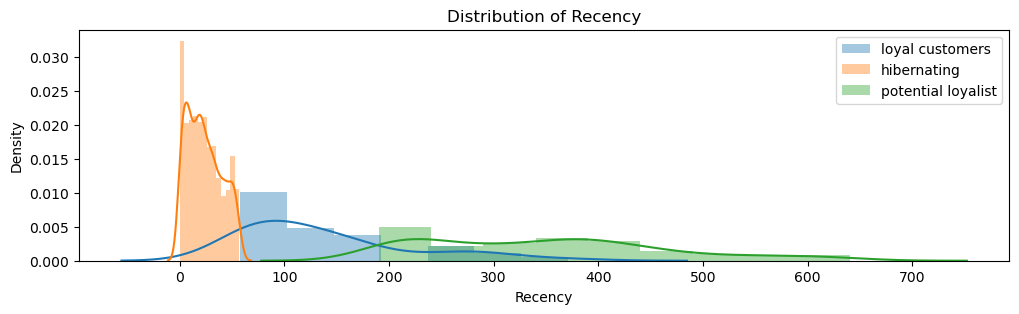

C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

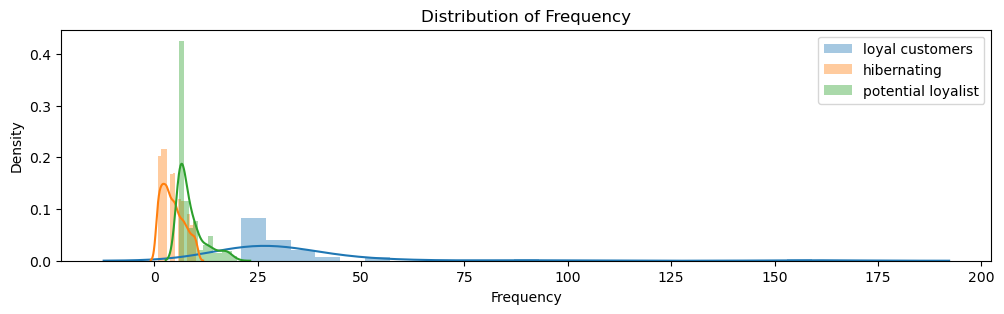

C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\prith\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

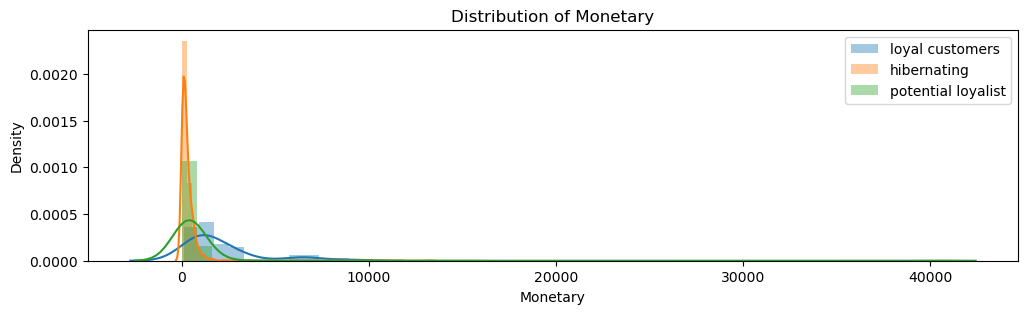

In [29]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in ['Recency','Frequency','Monetary']:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(rfm_df[rfm_df['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

## K means clustering for customer segmentation

In [58]:
cluster_df = pd.DataFrame()
for i in ['Recency','Frequency','Monetary']:
    cluster_df[i] = rfm_df[i]
cluster_df

C:\Users\prith\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


,Recency,Frequency,Monetary
Customer ID,,,
12482.0,449,32,3823.63
12835.0,417,49,2266.76
17850.0,301,159,8961.81
13093.0,266,88,3300.27
14590.0,424,28,861.93
...,...,...,...
13147.0,9,4,19.80
18174.0,6,2,4.03
14111.0,13,5,41.05


In [59]:
scaler = StandardScaler()
rfm_cluster_scaled = scaler.fit_transform(cluster_df)
rfm_cluster

C:\Users\prith\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\prith\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\prith\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common

Customer ID
12482.0    449.00
12835.0    417.00
17850.0    301.00
13093.0    266.00
14590.0    424.00
            ...  
13147.0     19.80
18174.0      4.03
14111.0     41.05
12367.0     35.20
13256.0      0.00
Length: 17826, dtype: float64

In [62]:
kmeans = KMeans(n_clusters = 4,max_iter = 50)
kmeans.fit(rfm_cluster)

ValueError: Expected 2D array, got 1D array instead:
array=[449.   417.   301.   ...  41.05  35.2    0.  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.